In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install -q findspark

# 1. START THE SPARK SESSION

In [2]:
from pyspark.sql import SparkSession
name="Crew member regression"


spark = SparkSession.builder.appName(name).master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/30 20:45:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

# 2. LOAD DATA

In [3]:
cruise= "/Users/jaimecastro/Downloads/cruise_ship_info.csv"
cruise_df=spark.read.format("csv")\
                    .options(header=True, inferschema=True,delimiter=",")\
                    .load(cruise)


# 3.BASIC DATA ANALYSIS

In [17]:
cruise_df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [31]:
cruise_df.toPandas().describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [18]:
cruise_df.toPandas().head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [25]:
cruise_df.toPandas().tail()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
153,Taurus,Star,22,3.341,0.66,2.79,0.33,50.62,0.59
154,Virgo,Star,14,76.800,19.60,8.79,9.67,39.18,12.00
155,Spirit,Windstar,25,5.350,1.58,4.40,0.74,33.86,0.88
156,Star,Windstar,27,5.350,1.67,4.40,0.74,32.04,0.88
157,Surf,Windstar,23,14.745,3.08,6.17,1.56,47.87,1.80


Null values

In [8]:
from pyspark.sql.functions import when, count, col

cruise_df.select([count(when(col(c).isNull(), c)).alias(c) for c in cruise_df.columns]).show() 



+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [59]:
cruise_df.select("Cruise_line").distinct().collect()

[Row(Cruise_line='Costa'),
 Row(Cruise_line='P&O'),
 Row(Cruise_line='Cunard'),
 Row(Cruise_line='Regent_Seven_Seas'),
 Row(Cruise_line='MSC'),
 Row(Cruise_line='Carnival'),
 Row(Cruise_line='Crystal'),
 Row(Cruise_line='Orient'),
 Row(Cruise_line='Princess'),
 Row(Cruise_line='Silversea'),
 Row(Cruise_line='Seabourn'),
 Row(Cruise_line='Holland_American'),
 Row(Cruise_line='Windstar'),
 Row(Cruise_line='Disney'),
 Row(Cruise_line='Norwegian'),
 Row(Cruise_line='Oceania'),
 Row(Cruise_line='Azamara'),
 Row(Cruise_line='Celebrity'),
 Row(Cruise_line='Star'),
 Row(Cruise_line='Royal_Caribbean')]

# EDA

In [71]:
cruise_df.createOrReplaceTempView('cruise_df')

Target variable: Crew

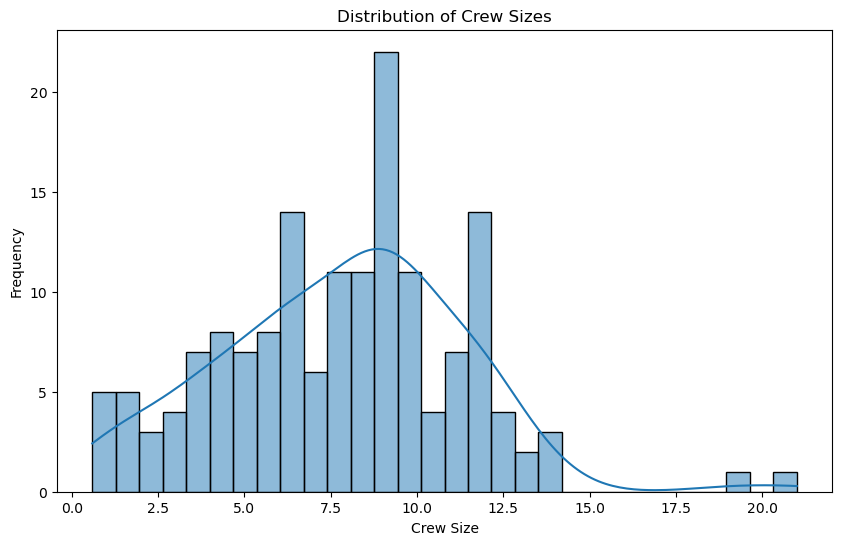

count    158.000000
mean       7.794177
std        3.503487
min        0.590000
25%        5.480000
50%        8.150000
75%        9.990000
max       21.000000
Name: crew, dtype: float64

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

cruise_df_pandas= cruise_df.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(cruise_df_pandas["crew"], kde=True, bins=30)
plt.title("Distribution of crew Sizes")
plt.xlabel("Crew Size")
plt.ylabel("Frequency")
plt.show()

cruise_df_pandas["crew"].describe()

In [72]:
spark.sql("""
    SELECT *
    FROM cruise_df
    WHERE crew > 17.5
"""
).toPandas()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Conquest,Carnival,11,110.0,29.74,9.53,14.88,36.99,19.1
1,Oasis,Royal_Caribbean,4,220.0,54.00,11.82,27.00,40.74,21.0


In [36]:
spark.sql("""
    SELECT *
    FROM cruise_df
    WHERE Cruise_line = 'Carnival' OR Cruise_line = 'Royal_Caribbean'
    ORDER BY crew DESC
"""
).toPandas()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Oasis,Royal_Caribbean,4,220.000,54.00,11.82,27.00,40.74,21.00
1,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
2,Freedom,Royal_Caribbean,7,158.000,43.70,11.12,18.00,36.16,13.60
3,Independence,Royal_Caribbean,5,160.000,36.34,11.12,18.17,44.03,13.60
4,Liberty,Royal_Caribbean,6,158.000,43.70,11.25,18.00,36.16,13.60
5,Adventure,Royal_Caribbean,12,138.000,31.14,10.20,15.57,44.32,11.85
6,Mariner,Royal_Caribbean,10,138.000,31.14,10.20,15.57,44.32,11.85
7,Navigator,Royal_Caribbean,11,138.000,31.14,10.20,15.57,44.32,11.85
8,Explorer,Royal_Caribbean,13,138.000,31.14,10.20,15.57,44.32,11.76
9,Voyager,Royal_Caribbean,14,138.000,31.14,10.20,15.57,44.32,11.76


The Royal_Caribbean outlier seems to be a normal value, since it´s Tonnage, Passengers, andcabins a

Check correlations between numeric variables and the crew

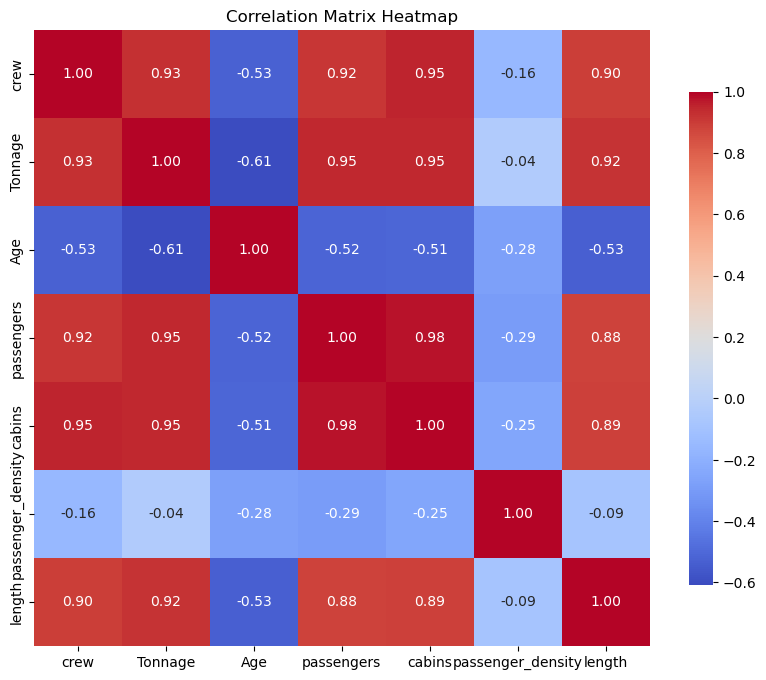

Tonnage is highly correlated with crew (Correlation: 0.93)
Age is mildly correlated with crew (Correlation: -0.53)
passengers is highly correlated with crew (Correlation: 0.92)
cabins is highly correlated with crew (Correlation: 0.95)
passenger_density is poorly correlated with crew (Correlation: -0.16)
length is highly correlated with crew (Correlation: 0.90)


In [67]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Select only the numeric columns.
numeric_columns = ["crew", "Tonnage", "Age", "passengers","cabins","passenger_density","length"]
#Assemble the vector in order to use the MLIB library.
#I assemble the vector: The columns i want to include and how will this columns be named in the vector
assembler_numeric = VectorAssembler(inputCols=numeric_columns, outputCol="features")
#the transform method is combining the inputs from the assembler columns and creating a single vector
vector_cruise_data_numeric = assembler_numeric.transform(cruise_df)

#Stores the correlation matrix of the features using the correlation.corr method
correlation = Correlation.corr(vector_cruise_data_numeric, "features")
#Stores the actual value of correlation matrix into an array
correlation_matrix = correlation.head()[0].toArray()

#Converts those values to a pandas DataFrame for plotting.
correlation_df=pd.DataFrame(correlation_matrix, columns=numeric_columns,index=numeric_columns)

#Creating the heatmap to represent the correlation data.
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

# Title and labels
plt.title("Correlation Matrix Heatmap")
plt.show()

#Explanation of the correlation results.
#Iterate over each colum name
for column in numeric_columns:
    if column != "crew":  # Skip the 'crew' column itself
#         corr_value = correlation_df.loc[column, "crew"]  #Extract the correlation value
        if (0.4 <= corr_value < 0.7) or (-0.7 < corr_value <= -0.4):
            print(f"{column} is mildly correlated with crew (Correlation: {corr_value:.2f})")
        elif (corr_value >= 0.7) or (corr_value <= -0.7):
            print(f"{column} is highly correlated with crew (Correlation: {corr_value:.2f})")
        elif (0 < corr_value < 0.4) or (-0.4 < corr_value < 0):
            print(f"{column} is poorly correlated with crew (Correlation: {corr_value:.2f})")


Since passenger density is lowly correlated with crew, I won´t use that feature in my prediction.

For the numeric values, I will use the Tonnage, Age, passengers, cabins and length of the ship, since they are correlated with the number of crew need for the ship

Relation of crew with the cruise_line

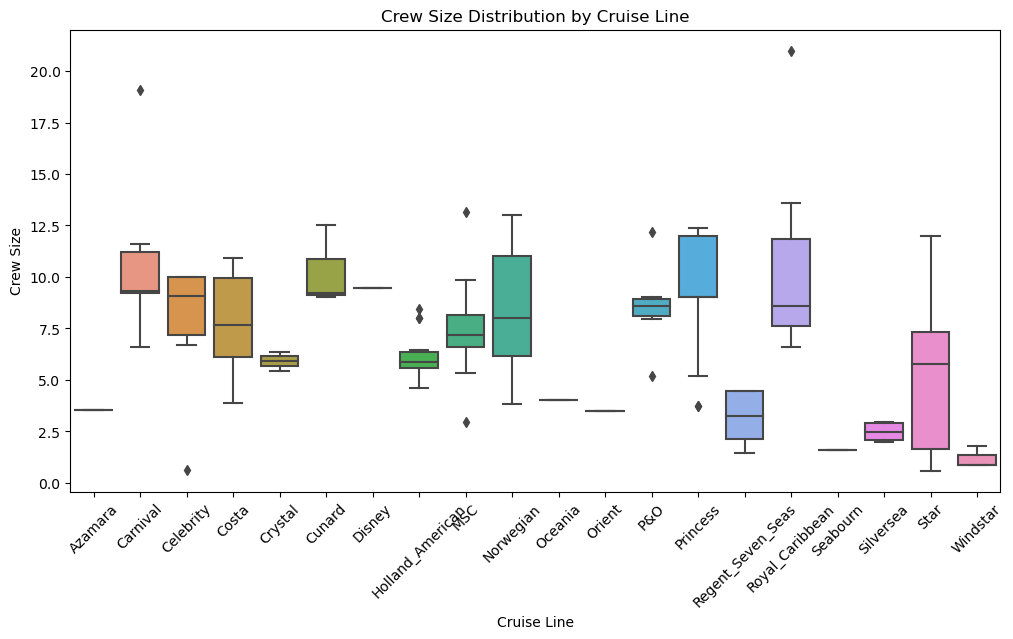

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cruise_line', y='crew', data=cruise_df_pandas)
plt.title("Crew Size Distribution by Cruise Line")
plt.xlabel("Cruise Line")
plt.ylabel("Crew Size")
plt.xticks(rotation=45)
plt.show()

There seems to be some outliers in most of the cruise lines. 

In [84]:
#Calculate mean crew size grouped by cruise_line
cruise_summary = cruise_df_pandas.groupby('Cruise_line')['crew'].agg(
    mean_crew='mean',
    q75_crew=lambda x: x.quantile(0.75)
).reset_index()

print(cruise_summary)

          Cruise_line  mean_crew  q75_crew
0             Azamara   3.550000    3.5500
1            Carnival  10.135909   11.2000
2           Celebrity   8.072000    9.9900
3               Costa   7.700000    9.9400
4             Crystal   5.905000    6.1325
5              Cunard  10.246667   10.8700
6              Disney   9.450000    9.4500
7    Holland_American   6.215000    6.3600
8                 MSC   7.540000    8.1675
9           Norwegian   8.087692   11.0000
10            Oceania   4.000000    4.0000
11             Orient   3.500000    3.5000
12                P&O   8.588333    8.9225
13           Princess   9.322353   12.0000
14  Regent_Seven_Seas   3.146000    4.4500
15    Royal_Caribbean  10.016522   11.8500
16           Seabourn   1.600000    1.6000
17          Silversea   2.472500    2.8900
18               Star   5.363333    7.3250
19           Windstar   1.186667    1.3400


Use string indexer to convert cruise_line to a numerical value

In [5]:
from pyspark.ml.feature import StringIndexer

indexer= StringIndexer(inputCol="Cruise_line",outputCol="Indexed_line")
IndexerModel= indexer.fit(cruise_df)

indexed_cruise_df= IndexerModel.transform(cruise_df)
print(indexed_cruise_df.head())


Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, Indexed_line=16.0)


# Let´s begin our Regression model

# 1. Assemble the features

In [41]:
from pyspark.ml.feature import VectorAssembler

data_assembler= VectorAssembler(inputCols=["Tonnage", "Age", "passengers","cabins","length","Indexed_line"],outputCol="features")
transformed_cruise_data=data_assembler.transform(indexed_cruise_df)

transformed_cruise_data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+--------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Indexed_line|            features|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+--------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|[30.2769999999999...|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|[30.2769999999999...|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|         1.0|[47.262,26.0,14.8...|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|         1.0|[110.0,11.0,29.74...|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|          

In [42]:
transformed_cruise_data.select("features").head(5)

[Row(features=DenseVector([30.277, 6.0, 6.94, 3.55, 5.94, 16.0])),
 Row(features=DenseVector([30.277, 6.0, 6.94, 3.55, 5.94, 16.0])),
 Row(features=DenseVector([47.262, 26.0, 14.86, 7.43, 7.22, 1.0])),
 Row(features=DenseVector([110.0, 11.0, 29.74, 14.88, 9.53, 1.0])),
 Row(features=DenseVector([101.353, 17.0, 26.42, 13.21, 8.92, 1.0]))]

# SELECT AND SPLIT OUR DATA TO CREATE THE MODEL

In [43]:
final_data= transformed_cruise_data.select(["features","crew"])

train_data, test_data= final_data.randomSplit([0.8,0.2])


In [44]:
print("Training data distribution:")
train_data.show()

print("Test data distribution:")
test_data.show()

Training data distribution:
+--------------------+----+
|            features|crew|
+--------------------+----+
|[2.329,12.0,0.94,...| 0.6|
|[3.341,22.0,0.66,...|0.59|
|[3.341,22.0,0.66,...|0.59|
|[5.35,25.0,1.58,0...|0.88|
|[5.35,27.0,1.67,0...|0.88|
|[10.0,21.0,2.08,1...| 1.6|
|[10.0,24.0,2.08,1...| 1.6|
|[12.5,27.0,3.94,0...|1.46|
|[14.745,23.0,3.08...| 1.8|
|[16.8,19.0,2.96,1...|1.97|
|[16.8,19.0,2.96,1...| 2.1|
|[16.852,36.0,9.52...|2.97|
|[19.093,21.0,8.0,...| 4.7|
|[19.2,16.0,3.2,1....|2.11|
|[22.08,48.0,8.26,...| 3.5|
|[25.0,12.0,3.88,1...|2.87|
|[25.0,13.0,3.82,1...|2.95|
|[28.0,40.0,11.5,4...| 3.8|
|[28.43,21.0,8.08,...| 4.0|
|[30.2769999999999...| 4.0|
+--------------------+----+
only showing top 20 rows

Test data distribution:
+--------------------+----+
|            features|crew|
+--------------------+----+
|[10.0,27.0,2.08,1...| 1.6|
|[25.0,23.0,7.76,3...|3.85|
|[30.2769999999999...|3.55|
|[30.2769999999999...|3.55|
|[30.2769999999999...| 4.0|
|[33.92,29.0,12.14...| 5.3

# CREATE THE ESTIMATOR

In [45]:
from pyspark.ml.regression import LinearRegression
#this is the algorithm as it is.
linear_reg_est=LinearRegression(featuresCol="features",labelCol="crew")

#Because I didn´t call my target variable "label", which is the default value, I have to/
#specify it´s name in labelCol. The rest of the parameters will use their default values, includin featuresCol.


# CREATE THE MODEL

Training the model

In [46]:
#Fit the model (the estimator) with the training data.
linear_reg_model=linear_reg_est.fit(train_data)

24/10/30 21:22:23 WARN Instrumentation: [98fc1073] regParam is zero, which might cause numerical instability and overfitting.


In [47]:
print("Coefficients: %s" % str(linear_reg_model.coefficients), 
      "\nIntercept: %s" % str(linear_reg_model.intercept), 
      "\nMean Squared Error: %s" % str(linear_reg_model.summary.meanSquaredError))


Coefficients: [0.010132677453161081,-0.01599231211812144,-0.13345294922045497,0.7745338553455717,0.4968453673755398,0.05560074047445543] 
Intercept: -1.4054483219493648 
Mean Squared Error: 0.6363011223795247


Doing the predictions

In [48]:
linear_reg_prediction=linear_reg_model.transform(test_data)

# EVALUATION OF THE MODEL

In [49]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="crew")
print(evaluator.explainParams())

labelCol: label column name. (default: label, current: crew)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error
                       var - explained variance. (default: rmse)
predictionCol: prediction column name. (default: prediction)
throughOrigin: whether the regression is through the origin. (default: False)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)


In [52]:
r2_linear_reg=evaluator.evaluate(linear_reg_prediction, { evaluator.metricName: "r2" })
print("R^2 metric for the model:", r2_linear_reg)

R^2 metric for the model: 0.8301027839681501
